# Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
from src import optimize
from src.portfolio import Portfolio



def gen_industry_stocks(n_stocks, market, industry, industry_name, sigma_noise, p_year=250):
    mu = pd.Series(np.random.uniform(low=-0.2, high=0.2, size=n_stocks))/p_year
    beta_market = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    beta_industry = pd.Series(np.random.uniform(low=0.5, high=2.0, size=n_stocks))
    stocks = pd.DataFrame()

    for i in range(n_stocks):
        stocks[f'{industry_name}_stock_{i}'] = mu[i] + beta_market[i]*market + beta_industry[i]*industry + norm.rvs(size=(1, num_samples))[0]*sigma_noise
    mu.index = stocks.columns
    return stocks, mu, beta_market, beta_industry

def information_ratio(equity_curve, p_year=250):
    return equity_curve.mean()/equity_curve.std()*p_year**0.5



p_year = 250
num_samples = p_year*4

sigma_market = 0.1/p_year**0.5
sigma_banks = 0.1/p_year**0.5
sigma_oil = 0.14/p_year**0.5
sigma_insurance = 0.07/p_year**0.5
sigma_tech = 0.2/p_year**0.5
sigma_bio = 0.12/p_year**0.5
sigma_pharma = 0.22/p_year**0.5
sigma_auto = 0.05/p_year**0.5
sigma_retail = 0.125/p_year**0.5
sigma_manufacturing = 0.1/p_year**0.5

sigma_noise = 0.1/p_year**0.5


Let's simulate a bunch of stocks belonging to different industries. Each stock is composed of a deterministic trend $\mu$, a loading on the market related stochastic trend $\beta_{market}$ and a loading on the industry specific stochastic trend $\beta_{industry}$. For each stock, $\mu$, $\beta_{market}$, and $\beta_{industry}$ are sampled from a uniform distribution. In the first simulation, I compare a mean-variance optimization with a naive diversification approch where each asset is equally weighted with sign of the expected value. At this point I should emphasize that I assume perfect knowledge of the expected value. Traditionally, the expected value is estimated by the in-sample first moment of the asset. In my example, this would actually make sense since the mean is a consistent estimator of the deterministic trend. In practive, howerver, there is probably not a constant deterministic trend. This is where the alpha model steps in, which is not the topic of this study and thus assumed given. 

In [2]:
def plot_equity_curve(log_returns):
    plt.plot(np.exp(log_returns.cumsum()))
    plt.title('Equity Curve')
    plt.xlabel('Period')
    plt.ylabel('Equity Value')
    plt.show()



def show_standard_optimized_equity(n_stocks, industry):
    trainig_pct = 0.5
    n_train = int(trainig_pct*num_samples)
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    industries = {}
    
    stocks, mu, beta_market, beta_industry = gen_industry_stocks(n_stocks, market, list(industry.values())[0], list(industry.keys())[0], sigma_noise, p_year)
    plot_equity_curve(stocks)
    weights = optimize.minimize_objective(mu.index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     mu, stocks[:n_train].cov(),
                                     0.0, 0.0,)

    portfolio_sm_is = np.dot(stocks.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    print('IR sm_is', IR_ann )
    plot_equity_curve(portfolio_sm_is)
    
    portfolio_equal_is = np.dot(stocks.values,mu.apply(np.sign)/mu.shape[0])[:n_train]
    IR_ann = information_ratio(portfolio_equal_is)
    print('IR equal_is', IR_ann )
    plot_equity_curve(portfolio_equal_is)

    portfolio_sm_oos = np.dot(stocks.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    print('IR sm_oos', IR_ann )
    plot_equity_curve(portfolio_sm_oos)
    
    portfolio_equal_oos = np.dot(stocks.values,mu.apply(np.sign)/mu.shape[0])[:n_train]
    IR_ann = information_ratio(portfolio_equal_oos)
    print('IR equal_is', IR_ann )
    plot_equity_curve(portfolio_equal_oos)
    
    return weights

The results below show that out of sample performance is decent if the number of assets is relatively small. It definently beats equal weighting.

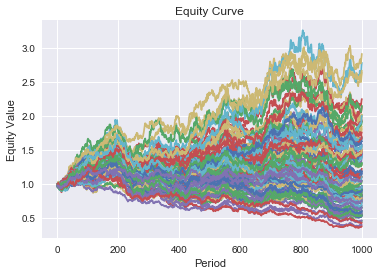

IR sm_is 12.080524240327364


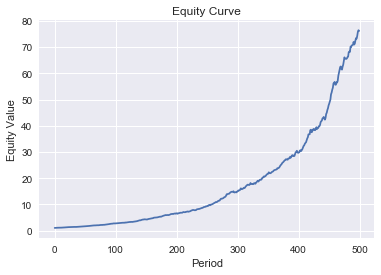

IR equal_is 5.1354209376769955


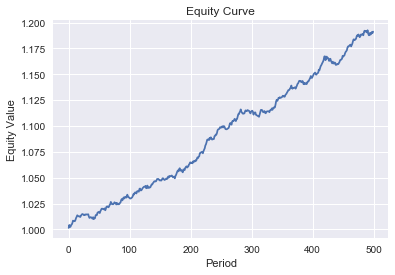

IR sm_oos 9.759413351006245


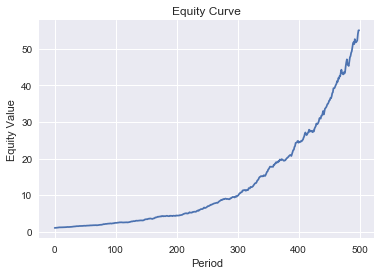

IR equal_is 5.1354209376769955


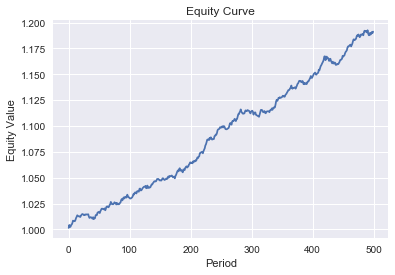

In [3]:
industry = {}
industry['manufacturing'] = norm.rvs(size=(1, num_samples))[0]*sigma_manufacturing
_ = show_standard_optimized_equity(n_stocks=100, industry=industry)

When the number of assets is relatively large, however, the out-of-sample performance is significantly smaller than the in-sample performance as demonstrated by the information ratio (IR). Even the very naive approach of equal weighting beats mean-variance optimization out-of-sample embarrassingly often.

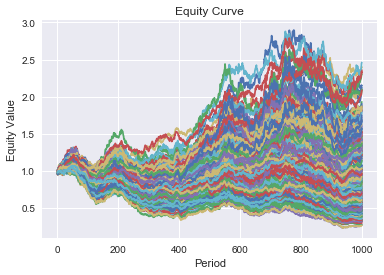

IR sm_is 33.12402696406134


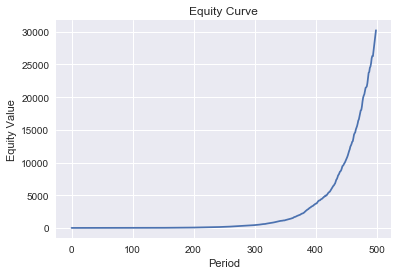

IR equal_is 10.992485576303212


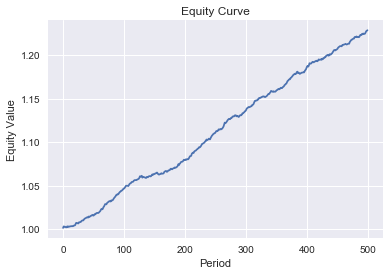

IR sm_oos 13.055863467928736


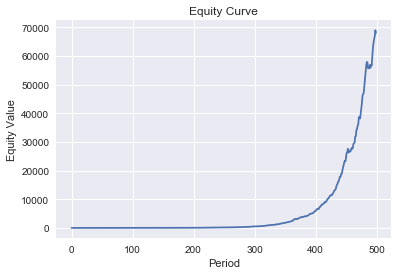

IR equal_is 10.992485576303212


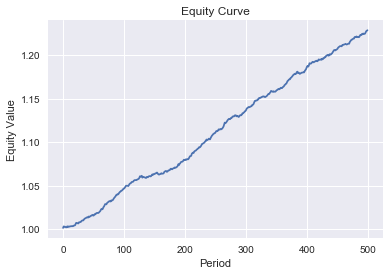

In [4]:
weights = show_standard_optimized_equity(n_stocks=300, industry=industry)

In [5]:
pf = Portfolio(assets=weights.keys(), position=pd.Series(weights), price=[1]*len(weights.keys()))
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))

Portfolio: 300 Assets, $30.12 Long, $30.12 Short
largest long: manufacturing_stock_289 0.6249032519806317
largest short: manufacturing_stock_233 -0.6233134637193901


In [6]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
manufacturing_stock_289,0.624903,1,1.0,0.0,0.624903
manufacturing_stock_151,0.571985,1,1.0,0.0,0.571985
manufacturing_stock_241,0.562936,1,1.0,0.0,0.562936
manufacturing_stock_74,0.556673,1,1.0,0.0,0.556673
manufacturing_stock_30,0.537316,1,1.0,0.0,0.537316


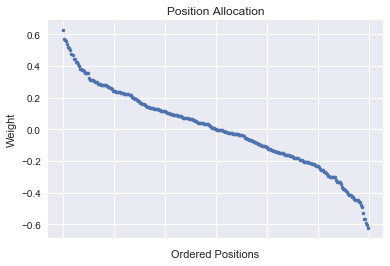

In [7]:
pf.portfolio_df.position_value.plot(style='.')
plt.title('Position Allocation')
plt.xlabel('Ordered Positions')
plt.ylabel('Weight')
plt.show()

Here you can see a typical result of mean-variance optimization. There are some very large positions. These are most likely due to estimation errors of the covariance matrix and thus undesirable. This problem is even greater when $\mu$, too, is estimated with error. As the number of assets grows, there is a higher likelihood of observing a extreme covariance value by chance and thus this problem actually grows with the number of assets. This is so common that it has a name. In the literature it goes by 'Error Maximization'. 

## Imposing Structure

To reduce Error Maximization we need to impose structure. One way to do this is by using our knowledge that stocks usually cluster (e.g., into certain industries). It seems like a good idea to encode this prior knowledge by mean-variance optimize stocks within clusters and then optimize allocation to these clusters. This is persued next and compared to the standard optimization.

In [8]:
trainig_pct = 0.5
n_train = int(trainig_pct*num_samples)
ir_sm_is = []
ir_sm_oos = []
ir_hier_is = []
ir_hier_oos = []
n_stocks = 30

for j in range(10):
    print('MC run: ', j)
    
    market = norm.rvs(size=(1, num_samples))[0]*sigma_market
    industries = {}
    industries['banks'] =  norm.rvs(size=(1, num_samples))[0]*sigma_banks
    industries['oil'] = norm.rvs(size=(1, num_samples))[0]*sigma_oil
    industries['insurance'] = norm.rvs(size=(1, num_samples))[0]*sigma_insurance
    industries['tech'] = norm.rvs(size=(1, num_samples))[0]*sigma_tech
    industries['bio'] = norm.rvs(size=(1, num_samples))[0]*sigma_bio
    industries['pharma'] = norm.rvs(size=(1, num_samples))[0]*sigma_pharma
    industries['auto'] = norm.rvs(size=(1, num_samples))[0]*sigma_auto
    industries['retail'] = norm.rvs(size=(1, num_samples))[0]*sigma_retail
    
    industries_stocks = {}
    industries_mu = {}
    industries_beta_market = {}
    industries_beta_industries = {}
    industries_weights = {}
    industries_portfolio = {}

    stocks_all = pd.DataFrame()
    expected_returns_all = pd.Series()

    for i in industries.keys():
        industries_stocks[i], industries_mu[i], industries_beta_market[i], industries_beta_industries[i] = gen_industry_stocks(n_stocks, market, industries[i], i, sigma_noise, p_year)
        stocks_all = pd.concat([stocks_all,industries_stocks[i]], axis=1)
        expected_returns_all = expected_returns_all.append(industries_mu[i])

        industries_weights[i] = optimize.minimize_objective(industries_mu[i].index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     industries_mu[i], industries_stocks[i][:n_train].cov(),
                                     0.0, 0.0,)
        industries_portfolio[i] = np.dot(industries_stocks[i].values,np.array(list(industries_weights[i].values())))


    #standard sample moments
    weights = optimize.minimize_objective(expected_returns_all.index,
                                     optimize.negative_sharpe,
                                     True,
                                     (-1, 1),
                                     expected_returns_all, stocks_all[:n_train].cov(),
                                     0.0, 0.0,)
    portfolio_sm_is = np.dot(stocks_all.values,np.array(list(weights.values())))[:n_train]
    IR_ann = information_ratio(portfolio_sm_is)
    ir_sm_is.append(IR_ann)
    print('IR sm_is', IR_ann )

    portfolio_sm_oos = np.dot(stocks_all.values,np.array(list(weights.values())))[n_train:]
    IR_ann = information_ratio(portfolio_sm_oos)
    ir_sm_oos.append(IR_ann)
    print('IR sm_oos', IR_ann )

    # hierarchical
    # optimize allocation to industry
    industry_weights = optimize.minimize_objective(industries.keys(),
                                     optimize.negative_sharpe,
                                     False,
                                     (-1, 1),
                                     pd.Series(index=industries.keys(), data=[0.1]*len(industries.keys())),
                                     pd.DataFrame(industries_portfolio).cov()[:n_train]*100000,
                                     0.0, 0.0,)
#     # equal weighting industries
#     for i in industry_weights.keys():
#         industry_weights[i] = 1/len(industries)

    print(industry_weights)
    portfolio_hier_is = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[:n_train]

    IR_ann = information_ratio(portfolio_hier_is)
    print('IR hier is', IR_ann )
    ir_hier_is.append(IR_ann)

    portfolio_hier_oos = np.dot(pd.DataFrame(industries_portfolio).values,
                            np.array(list(industry_weights.values())))[n_train:]

    IR_ann = information_ratio(portfolio_hier_oos)
    print('IR hier oos', IR_ann )
    ir_hier_oos.append(IR_ann)


MC run:  0
IR sm_is 25.3699875760267
IR sm_oos 11.990014694542156
{'banks': 0.15385764815254516, 'oil': 0.19059981096278808, 'insurance': 0.02391061170436186, 'tech': 0.018956049384324557, 'bio': 0.004945047456412911, 'pharma': 0.44648200487998446, 'auto': 0.074763600482615, 'retail': 0.08648522697696806}
IR hier is 15.680995575600042
IR hier oos 13.700290856996926
MC run:  1
IR sm_is 25.03281471982519
IR sm_oos 14.010910468382297
{'banks': 0.27188048274606863, 'oil': 0.12467761908477605, 'insurance': 0.12651435499025526, 'tech': 0.12262427367349477, 'bio': 0.16866141759278716, 'pharma': 0.04775002174471936, 'auto': 0.03008039170742452, 'retail': 0.10781143846047424}
IR hier is 18.3239942722721
IR hier oos 17.439428145895103
MC run:  2
IR sm_is 22.932238117237706
IR sm_oos 12.279898887620611
{'banks': 0.09661291386358964, 'oil': 0.23030731835295903, 'insurance': 0.09778683540104627, 'tech': 0.36558532220505663, 'bio': 0.08894493578868903, 'pharma': 0.04768312151750904, 'auto': 0.045994

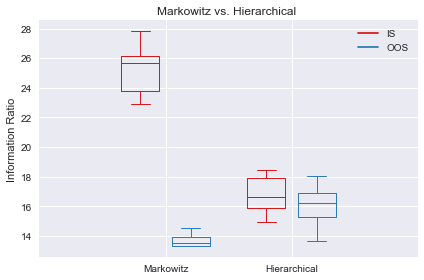

In [9]:
data_a = [ir_sm_is, ir_hier_is]
data_b = [ir_sm_oos, ir_hier_oos]

ticks = ['Markowitz', 'Hierarchical']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)

set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='IS')
plt.plot([], c='#2C7BB6', label='OOS')
plt.legend()
plt.title('Markowitz vs. Hierarchical ')
plt.ylabel('Information Ratio')
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 8)
plt.tight_layout()
# plt.savefig('boxcompare.png')

In [10]:
performance_factor = np.mean(ir_hier_oos)/np.mean(ir_sm_oos)
print('OOS performance gain factor', performance_factor)

OOS performance gain factor 1.1925597676649773


In [11]:
Portfolio?
dir(Portfolio)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'from_dataframe',
 'gross_exposure',
 'long_exposure',
 'long_exposure_pct',
 'longs',
 'net_exposure',
 'position',
 'sector_net_exposures',
 'short_exposure',
 'short_exposure_pct',
 'shorts',
 'trade']

In [12]:
pf = Portfolio(assets=weights.keys(),
               position=pd.Series(weights),
               price=[1]*len(weights.keys()),
               sector_id=pd.Series(list(weights.keys())).str[:3].values
              )
print(pf)
print('largest long:', pf[0], pf.position(pf[0]))
print('largest short:', pf[-1], pf.position(pf[-1]))
pf.sector_net_exposures()

Portfolio: 240 Assets, $33.05 Long, $33.05 Short
largest long: auto_stock_13 1.0
largest short: tech_stock_18 -0.7404833107412009


,position_value
sector_id,
aut,-1.301102
ban,-0.432585
bio,-0.460176
ins,0.557083
oil,1.645054
pha,0.402924
ret,0.253202
tec,-0.664401


In [15]:
pf.portfolio_df.head()

,position,price,factor_value,sector_id,position_value
auto_stock_13,1.000000,1,1.0,aut,1.000000
oil_stock_2,0.924874,1,1.0,oil,0.924874
auto_stock_29,0.718137,1,1.0,aut,0.718137
retail_stock_28,0.698909,1,1.0,ret,0.698909
retail_stock_2,0.685869,1,1.0,ret,0.685869


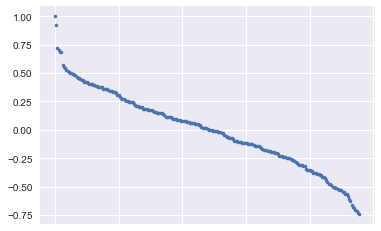

In [14]:
pf.portfolio_df.position_value.plot(style='.')